In [1]:
from sklearn.metrics import explained_variance_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import optuna
from optuna import samplers
from sklearn.model_selection import cross_val_score

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
X = pd.read_csv("data_processed/train/X_train_processed.csv", index_col="level_0")
Y = pd.read_csv("data_processed/train/labels_train_processed.csv", index_col="level_0")
Xt = pd.read_csv("data_processed/test/X_test_processed.csv", index_col="level_0")

In [3]:
X = X[:300_000]
Y = Y[:300_000]
y = Y["energy_consumption_per_annum"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, shuffle=True, test_size=0.2
)

In [5]:
xgb_hyp = XGBRegressor(max_depth=6, n_estimators=164)
xgb_hyp.fit(X_train, y_train)
y_pred = xgb_hyp.predict(X_test)
print(explained_variance_score(y_test, y_pred))

0.7728789054220253


In [17]:
y_pred_xt = xgb_hyp.predict(Xt)
y_pred_xt = pd.DataFrame(y_pred_xt, index=Xt.index)
y_pred_xt.columns = ["energy_consumption_per_annum"]
y_pred_xt.to_csv("predictions_xgb.csv")

In [11]:
# Tuning with optuna
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 3, 10)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    eta = trial.suggest_float("eta", 0.01, 0.2, log=True)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1, log=True)
    reg = XGBRegressor(
        **trial.params,
        random_state=42,
    )

    return np.mean(
        cross_val_score(
            reg,
            X_train,
            y_train,
            cv=2,
            n_jobs=-1,
            scoring="explained_variance",
            verbose=3,
        )
    )


sampler = samplers.TPESampler(seed=10)
study = optuna.create_study(sampler=sampler, direction="maximize")
optuna.logging.disable_default_handler()  # limit verbosity
study.optimize(objective, n_trials=10, n_jobs=-1, show_progress_bar=True)

# Show best result
print(study.best_trial.params)
print(study.best_trial.value)

[I 2023-01-15 12:54:40,510] A new study created in memory with name: no-name-790ebae6-52d6-4d93-b012-2f39aa07ecdb
/opt/anaconda3/lib/python3.9/site-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen import

[CV] END ................................ score: (test=0.758) total time= 2.5min
[CV] END ................................ score: (test=0.762) total time= 2.5min
[I 2023-01-15 12:57:12,999] Trial 3 finished with value: 0.7598194034942123 and parameters: {'max_depth': 4, 'n_estimators': 449, 'eta': 0.1884018578059759, 'colsample_bytree': 0.6611499347537041}. Best is trial 3 with value: 0.7598194034942123.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ................................ score: (test=0.774) total time= 7.0min
[CV] END ................................ score: (test=0.776) total time= 7.0min


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  7.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[I 2023-01-15 13:01:42,841] Trial 1 finished with value: 0.7749299839914023 and parameters: {'max_depth': 6, 'n_estimators': 906, 'eta': 0.07418610772367254, 'colsample_bytree': 0.566395067762454}. Best is trial 1 with value: 0.7749299839914023.
[CV] END ................................ score: (test=0.756) total time= 5.5min


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  8.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  8.3min finished


[CV] END ................................ score: (test=0.754) total time= 5.8min
[I 2023-01-15 13:03:00,908] Trial 5 finished with value: 0.7554203055321855 and parameters: {'max_depth': 3, 'n_estimators': 956, 'eta': 0.13352619730044368, 'colsample_bytree': 0.9059041701005918}. Best is trial 1 with value: 0.7749299839914023.
[CV] END ................................ score: (test=0.765) total time= 9.0min


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 10.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 10.6min finished


[CV] END ................................ score: (test=0.764) total time=10.5min
[I 2023-01-15 13:05:15,364] Trial 0 finished with value: 0.7645546371371077 and parameters: {'max_depth': 7, 'n_estimators': 826, 'eta': 0.02633421007019914, 'colsample_bytree': 0.8164666653719898}. Best is trial 1 with value: 0.7749299839914023.
[CV] END ................................ score: (test=0.737) total time= 1.7min
[CV] END ................................ score: (test=0.697) total time= 2.7min


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 11.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 11.3min finished


[CV] END ................................ score: (test=0.698) total time= 3.2min
[I 2023-01-15 13:05:56,118] Trial 7 finished with value: 0.6976608089342639 and parameters: {'max_depth': 4, 'n_estimators': 594, 'eta': 0.02310859041052838, 'colsample_bytree': 0.5701136770712346}. Best is trial 1 with value: 0.7749299839914023.


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 12.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 12.3min finished


[CV] END ................................ score: (test=0.736) total time= 1.7min
[I 2023-01-15 13:06:59,195] Trial 4 finished with value: 0.7362665307770779 and parameters: {'max_depth': 4, 'n_estimators': 321, 'eta': 0.10558082325646433, 'colsample_bytree': 0.5718551538129679}. Best is trial 1 with value: 0.7749299839914023.
[CV] END ................................ score: (test=0.758) total time= 2.1min


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 10.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 10.7min finished


[CV] END ................................ score: (test=0.757) total time= 2.2min
[I 2023-01-15 13:07:53,276] Trial 8 finished with value: 0.7571735679831159 and parameters: {'max_depth': 8, 'n_estimators': 199, 'eta': 0.06875250328647936, 'colsample_bytree': 0.5870618601222806}. Best is trial 1 with value: 0.7749299839914023.
[CV] END ................................ score: (test=0.741) total time= 6.2min


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 13.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 13.2min finished


[CV] END ................................ score: (test=0.742) total time= 6.2min
[I 2023-01-15 13:07:55,288] Trial 6 finished with value: 0.7415524554282834 and parameters: {'max_depth': 6, 'n_estimators': 628, 'eta': 0.023839874559311434, 'colsample_bytree': 0.7267069408649993}. Best is trial 1 with value: 0.7749299839914023.
[CV] END ................................ score: (test=0.776) total time=13.8min
[CV] END ................................ score: (test=0.718) total time= 3.4min


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 14.8min finished


[CV] END ................................ score: (test=0.773) total time=14.8min
[I 2023-01-15 13:09:30,819] Trial 2 finished with value: 0.7744715206864696 and parameters: {'max_depth': 9, 'n_estimators': 959, 'eta': 0.04053953953150947, 'colsample_bytree': 0.8426780022998981}. Best is trial 1 with value: 0.7749299839914023.


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  8.4min finished


[CV] END ................................ score: (test=0.717) total time= 3.1min
[I 2023-01-15 13:10:05,201] Trial 9 finished with value: 0.7177343998846961 and parameters: {'max_depth': 3, 'n_estimators': 678, 'eta': 0.06110014822917703, 'colsample_bytree': 0.8697205818494951}. Best is trial 1 with value: 0.7749299839914023.
{'max_depth': 6, 'n_estimators': 906, 'eta': 0.07418610772367254, 'colsample_bytree': 0.566395067762454}
0.7749299839914023


In [13]:
xgb_hyp = XGBRegressor(
    max_depth=6,
    n_estimators=906,
    eta=0.07418610772367254,
    colsample_bytree=0.566395067762454,
)
xgb_hyp.fit(X_train, y_train)
y_pred = xgb_hyp.predict(X_test)
print(explained_variance_score(y_test, y_pred))

0.7912705536827069


In [16]:
y_pred_xt = xgb_hyp.predict(Xt)
y_pred_xt = pd.DataFrame(y_pred_xt, index=Xt.index)
y_pred_xt.columns = ["energy_consumption_per_annum"]
y_pred_xt.to_csv("predictions_xgb_hyp.csv")

In [6]:
def best_features(model, X_train, threshold):
    features_importances = []
    index_best_features = []
    list_results = model.feature_importances_.tolist()
    best_features = []
    for i in range(len(list_results)):
        if list_results[i] > threshold:
            index_best_features.append(i)
            features_importances.append(list_results[i])
            best_features.append(X_train.columns[i])
    return best_features, features_importances

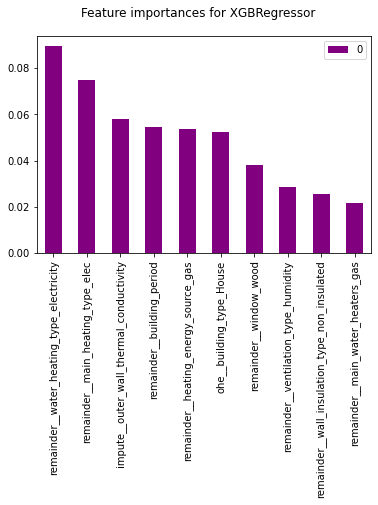

In [11]:
best_features_xgb, features_importance_xgb = best_features(xgb_hyp, X_train, 0.02)

pd.DataFrame(features_importance_xgb, index=best_features_xgb).sort_values(
    0, ascending=False
).plot.bar(color="purple")
plt.suptitle("Feature importances for XGBRegressor")
plt.legend()
plt.show()

In [66]:
# filename = "best_model.joblib"
# joblib.dump(xgb_hyp, filename)

['best_model.joblib']